In [1]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

In [2]:
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

def train_and_evaluate_(model, X_train, y_train, X_test, y_test, cv=5):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r_squared(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_mse = -cv_scores.mean()

    return mse, cv_mse, mae, r2

In [3]:
df = pd.read_csv("../Machine-Learning-Model-Analysis/Regression-Modelling/california-housing-prices.csv")
# Print the first few rows
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df.apply(lambda x: sum(x.isnull()))

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
#drop missing columns
df = df.dropna(subset=df.columns)
df.apply(lambda x: sum(x.isnull()))

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
len(df)

20433

In [8]:
df.ocean_proximity.nunique()

5

In [9]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
encoded_data = pd.get_dummies(df, columns = categorical_columns, drop_first=True)
encoded_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,True,False


#### Split Data:

In [11]:
X = encoded_data[['longitude', 'latitude', 'housing_median_age', 'total_rooms','total_bedrooms', 'population',
                  'households', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 
                  'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']]
y = encoded_data['median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Train and evaluate multiple models with cross-validation

In [13]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=0.2),  # Adjust alpha as needed
    "Lasso Regression": Lasso(alpha=0.2),  # Adjust alpha as needed
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

best_model = None
best_mse = float('inf')
best_cv_mse = float('inf')
results = []

for model_name, model in models.items():
    mse, cv_mse, mae, r2 = train_and_evaluate_(model, X_train, y_train, X_test, y_test)
    results.append({'Model': model_name, 'MSE': mse, 'CV MSE': cv_mse, 'MAE': mae, 'R-Squard': round(r2, 2)})
    print(f"{model_name}: MSE = {mse}, CV MSE = {cv_mse}")
    if cv_mse < best_cv_mse:
        best_model = model
        best_mse = mse
        best_cv_mse = cv_mse

print("Best Model:", best_model)

Linear Regression: MSE = 4802173538.6041565, CV MSE = 4732715571.3800535
Ridge Regression: MSE = 4800270015.928118, CV MSE = 4732447896.912088
Lasso Regression: MSE = 4802008698.9068, CV MSE = 4732687090.677056
Random Forest: MSE = 2378317289.567475, CV MSE = 2434356373.9637837
Gradient Boosting: MSE = 3199648337.5456276, CV MSE = 3045565143.806124
Best Model: RandomForestRegressor(random_state=42)


In [14]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results)
df_results

,Model,MSE,CV MSE,MAE,R-Squard
0,Linear Regression,4.802174e+09,4.732716e+09,50413.433308,0.65
1,Ridge Regression,4.800270e+09,4.732448e+09,50407.863822,0.65
2,Lasso Regression,4.802009e+09,4.732687e+09,50412.962090,0.65
3,Random Forest,2.378317e+09,2.434356e+09,31677.918808,0.83
4,Gradient Boosting,3.199648e+09,3.045565e+09,39267.120388,0.77


#### Training with the best model

In [26]:
rf_model = RandomForestRegressor(random_state=42)
mse, cv_mse, mae, r2 = train_and_evaluate_(rf_model, X_train, y_train, X_test, y_test)

imp_feature = rf_model.feature_importances_
imp_df = pd.DataFrame({
    "Features": X_train.columns,
    "Importance": imp_feature
}).sort_values(by='Importance', ascending=False)

imp_df['Cummulative_Importance'] = imp_df['Importance'].cumsum().round(2)
imp_df

,Features,Importance,Cummulative_Importance
7,median_income,0.485142,0.49
8,ocean_proximity_INLAND,0.142842,0.63
0,longitude,0.109385,0.74
1,latitude,0.104899,0.84
2,housing_median_age,0.050458,0.89
5,population,0.032718,0.93
3,total_rooms,0.023751,0.95
4,total_bedrooms,0.021996,0.97
6,households,0.018917,0.99
11,ocean_proximity_NEAR OCEAN,0.008189,1.00


In [32]:
print(f"MSE: {round(mse, 2):.2f}, CV MSE: {round(cv_mse, 2):.2f}, MAE: {round(mae, 2):.2f}, R2: {round(r2, 2):.2f}")

MSE: 2378317289.57, CV MSE: 2434356373.96, MAE: 31677.92, R2: 0.83


We can see from the above that with less features we are able to still achieve an 82% explainablty of the variability in the median house value.

#### Storing the Best Model:

In [35]:
# Store the best model to a file
with open('best_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

#### Load the best model from the file

In [38]:
# Load the best model from the file
with open('best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [40]:
X_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
14416,-117.24,32.79,20.0,961.0,278.0,525.0,254.0,3.1838,False,False,False,True
16383,-121.29,38.01,2.0,6403.0,1116.0,3327.0,957.0,4.4871,True,False,False,False
7731,-118.14,33.92,31.0,3731.0,853.0,2313.0,801.0,3.2237,False,False,False,False
1410,-122.07,37.94,30.0,1260.0,276.0,707.0,221.0,2.8920,False,False,True,False
1335,-121.89,37.99,4.0,2171.0,597.0,928.0,461.0,4.1016,True,False,False,False


In [42]:
y_test.head()

14416    245800.0
16383    137900.0
7731     218200.0
1410     220800.0
1335     170500.0
Name: median_house_value, dtype: float64

In [44]:
# Use the loaded model to make predictions on new data
new_data = X_test
predictions = loaded_model.predict(new_data)

In [46]:
predictions

array([217892., 151202., 189054., ...,  86718., 108478., 117344.])

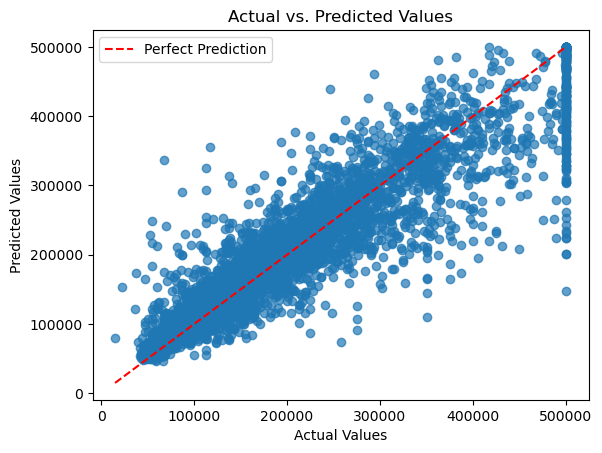

In [50]:
import matplotlib.pyplot as plt

y_true = y_test
# Assuming you have your actual values in y_true and predicted values in y_pred

# Create a scatter plot
plt.scatter(y_true, predictions, alpha=0.7)

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line representing perfect prediction
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label="Perfect Prediction")

# Show the plot
plt.legend()
plt.show()

#### A Custom Predict Function

In [65]:
# Load the saved model
def load_model():
    """Loads the best model from the specified pickle file."""
    with open('best_model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
    return loaded_model

# Load the model outside the Flask app
loaded_model = load_model()

def predict(longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity):
    # Create a DataFrame with the input features

    data = {
        'longitude': longitude,
        'latitude': latitude,
        'housing_median_age': housing_median_age,
        'total_rooms': total_rooms,
        'total_bedrooms': total_bedrooms,
        'population': population,
        'households': households,
        'median_income': median_income,
        'ocean_proximity': ocean_proximity
        }
    
    data = pd.DataFrame(data, index=[0])
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Create dummy variables for the categorical feature
    data = pd.get_dummies(data, columns=categorical_columns)
    
    # Ensure that the input DataFrame has the same columns as the training data
    model_columns = loaded_model.feature_names_in_
    input_data = data.reindex(columns=model_columns, fill_value=False)

    # Predict the outcome using the saved model
    prediction = loaded_model.predict(input_data)[0]
    return prediction

In [59]:
 X_test.iloc[0, :]

longitude                    -117.24
latitude                       32.79
housing_median_age              20.0
total_rooms                    961.0
total_bedrooms                 278.0
population                     525.0
households                     254.0
median_income                 3.1838
ocean_proximity_INLAND         False
ocean_proximity_ISLAND         False
ocean_proximity_NEAR BAY       False
ocean_proximity_NEAR OCEAN      True
Name: 14416, dtype: object

In [67]:
# Example usage
result = predict(-117.24,32.79, 20.0, 961.0, 278.0, 525.0, 254.0, 3.1838, 'NEAR OCEAN')
print("Predicted outcome:", result) # predicted Y

Predicted outcome: 217892.0


In [71]:
y_test[0] # actual Y

452600.0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load training and live data (replace with your actual paths)
training_data = pd.read_csv("training_data.csv")
live_data = pd.read_csv("live_data.csv")

# Calculate statistical metrics (adjust as needed)
def calculate_stats(df):
  return {
    'mean': df.mean(),
    'median': df.median(),
    'std': df.std(),
    'min': df.min(),
    'max': df.max(),
    'quantile_25': df.quantile(0.25),
    'quantile_75': df.quantile(0.75)
  }

training_stats = calculate_stats(training_data)
live_stats = calculate_stats(live_data)

# Compare metrics
for column in training_data.columns:
  print(f"\nColumn: {column}")
  print("Training Data:")
  print(training_stats[column])
  print("Live Data:")
  print(live_stats[column])

  # Visualize differences (optional)
  plt.figure(figsize=(10, 5))
  sns.distplot(training_data[column], label="Training Data")
  sns.distplot(live_data[column], label="Live Data")
  plt.title(f"Distribution of {column}")
  plt.legend()
  plt.show()